In [1]:
class  Function(object):
    def forward(self): 
        raise NotImplementedError
    
    def backward(self): 
        raise NotImplementedError
    
    def getParams(self): 
        return []

In [12]:
class Linear(Function):
    def __init__(self,in_nodes,out_nodes):
        self.weights = torch.Tensor((in_nodes,out_nodes))
        self.bias    = torch.Tensor((1,out_nodes))
        self.type = 'linear'

    def forward(self,x):
        output = np.dot(x,self.weights.data)+self.bias.data
        self.input = x 
        return output

    def backward(self,d_y):
        self.weights.grad += np.dot(self.input.T,d_y)
        self.bias.grad    += np.sum(d_y,axis=0,keepdims=True)
        grad_input         = np.dot(d_y,self.weights.data.T)
        return grad_input

    def getParams(self):
        return [self.weights,self.bias]

In [3]:
class Optimizer(object):
    def __init__(self,parameters):
        self.parameters = parameters
    
    def step(self): 
        raise NotImplementedError

    def zeroGrad(self):
        for p in self.parameters:
            p.grad = 0.

In [4]:
class SGD(Optimizer):
    def __init__(self,parameters,lr=.001,weight_decay=0.0,momentum = .9):
        super().__init__(parameters)
        self.lr           = lr
        self.weight_decay = weight_decay
        self.momentum     = momentum
        self.velocity     = []
        for p in parameters:
            self.velocity.append(np.zeros_like(p.grad))

    def step(self):
        for p,v in zip(self.parameters,self.velocity):
            v = self.momentum*v+p.grad+self.weight_decay*p.data
            p.data=p.data-self.lr*v

In [15]:
class  ReLU(Function):
    def __init__(self,inplace=True):
        self.type    = 'activation'
        self.inplace = inplace
    
    def forward(self,x):
        if self.inplace:
            x[x<0] = 0.
            self.activated = x
        else:
            self.activated = x*(x>0)
        
        return self.activated

    def backward(self,d_y):
        return d_y*(self.activated>0)

In [5]:
class Model():
    def __init__(self):
        self.computation_graph = []
        self.parameters        = []

    def add(self,layer):
        self.computation_graph.append(layer)
        self.parameters+=layer.getParams()

    def __innitializeNetwork(self):
        for f in self.computation_graph:
            if f.type=='linear':
                weights,bias = f.getParams()
                weights.data = .01*np.random.randn(weights.data.shape[0],weights.data.shape[1])
                bias.data    = 0.

    def fit(self,data,target,batch_size,num_epochs,optimizer,loss_fn):
        loss_history = []
        self.__innitializeNetwork()
        data_gen = DataGenerator(data,target,batch_size)
        itr = 0
        for epoch in range(num_epochs):
            for X,Y in data_gen:
                optimizer.zeroGrad()
                for f in self.computation_graph: X=f.forward(X)
                loss = loss_fn.forward(X,Y)
                grad = loss_fn.backward()
                for f in self.computation_graph[::-1]: grad = f.backward(grad) 
                loss_history+=[loss]
                print("Loss at epoch = {} and iteration = {}: {}".format(epoch,itr,loss_history[-1]))
                itr+=1
                optimizer.step()
        
        return loss_history
    
    def predict(self,data):
        X = data
        for f in self.computation_graph: X = f.forward(X)
        return X

In [8]:
class SoftmaxWithLoss(Function):
    def __init__(self):
        self.type = 'normalization'

    def forward(self,x,target):
        unnormalized_proba = np.exp(x-np.max(x,axis=1,keepdims=True))
        self.proba         = unnormalized_proba/np.sum(unnormalized_proba,axis=1,keepdims=True)
        self.target        = target
        loss               = -np.log(self.proba[range(len(target)),target]) 
        return loss.mean()

    def backward(self):
        gradient = self.proba
        gradient[range(len(self.target)),self.target]-=1.0
        gradient/=len(self.target)
        return gradient

In [9]:
def genSpiralData(points_per_class,num_classes):
    data   = np.ndarray((points_per_class*num_classes,2),np.float32)
    target = np.ndarray((points_per_class*num_classes,),np.uint8)
    r = np.linspace(0,1,points_per_class)
    radians_per_class = 2*np.pi/num_classes
    for i in range(num_classes):
        t = np.linspace(i*radians_per_class,(i+1.5)*radians_per_class,points_per_class)+0.1*np.random.randn(points_per_class)
        data[i*points_per_class:(i+1)*points_per_class] = np.c_[r*np.sin(t),r*np.cos(t)]
        target[i*points_per_class:(i+1)*points_per_class] = i

    return  data,target

In [10]:
def plot2DDataWithDecisionBoundary(data,target,model):
    x_min,x_max = np.min(data[:,0])-.5,np.max(data[:,0])+.5
    y_min,y_max = np.min(data[:,1])-.5,np.max(data[:,1])+.5
    X,Y = np.arange(x_min,x_max,.02),np.arange(y_min,y_max,.02)
    XX,YY = np.meshgrid(X,Y)
    Z = np.argmax(model.predict(np.c_[XX.ravel(),YY.ravel()]),axis=1).reshape(XX.shape)
    plt.contourf(XX,YY,Z,cmap=plt.cm.seismic)
    plt.scatter(x=data[:,0],y=data[:,1],c=target,cmap=plt.cm.seismic)
    plt.show()

Loss at epoch = 0 and iteration = 0: 1.0987300515412037
Loss at epoch = 0 and iteration = 1: 1.091778907497933
Loss at epoch = 0 and iteration = 2: 1.1128766650145345
Loss at epoch = 0 and iteration = 3: 1.0857809935703042
Loss at epoch = 0 and iteration = 4: 1.059050791710595
Loss at epoch = 0 and iteration = 5: 1.132127949638789
Loss at epoch = 0 and iteration = 6: 1.0978598823906869
Loss at epoch = 0 and iteration = 7: 1.1332195121270412
Loss at epoch = 0 and iteration = 8: 1.1738531641058645
Loss at epoch = 0 and iteration = 9: 1.09599547053014
Loss at epoch = 0 and iteration = 10: 1.1227566807092717
Loss at epoch = 0 and iteration = 11: 1.0891199556014954
Loss at epoch = 0 and iteration = 12: 1.0844184363370022
Loss at epoch = 0 and iteration = 13: 1.101438225856802
Loss at epoch = 0 and iteration = 14: 1.0818939411151578
Loss at epoch = 1 and iteration = 15: 1.1219221852056624
Loss at epoch = 1 and iteration = 16: 1.0789822457881217
Loss at epoch = 1 and iteration = 17: 1.0440618

Loss at epoch = 15 and iteration = 239: 0.20542711306227818
Loss at epoch = 16 and iteration = 240: 0.5080765242133303
Loss at epoch = 16 and iteration = 241: 0.16815960699293744
Loss at epoch = 16 and iteration = 242: 0.4732759099859304
Loss at epoch = 16 and iteration = 243: 0.47404851086404276
Loss at epoch = 16 and iteration = 244: 0.2808491182842305
Loss at epoch = 16 and iteration = 245: 0.7503754381940227
Loss at epoch = 16 and iteration = 246: 0.585096139848719
Loss at epoch = 16 and iteration = 247: 0.5813138094061905
Loss at epoch = 16 and iteration = 248: 0.5760140473546241
Loss at epoch = 16 and iteration = 249: 0.23645410508060113
Loss at epoch = 16 and iteration = 250: 0.4303334032428129
Loss at epoch = 16 and iteration = 251: 0.2426542858821635
Loss at epoch = 16 and iteration = 252: 0.5638575701339095
Loss at epoch = 16 and iteration = 253: 0.3370045926045705
Loss at epoch = 16 and iteration = 254: 0.2686822803214072
Loss at epoch = 17 and iteration = 255: 0.34534378176

Loss at epoch = 31 and iteration = 478: 0.2137689241590762
Loss at epoch = 31 and iteration = 479: 0.28752349938394406
Loss at epoch = 32 and iteration = 480: 0.4358663488981317
Loss at epoch = 32 and iteration = 481: 0.24569396564508783
Loss at epoch = 32 and iteration = 482: 0.2305981465625988
Loss at epoch = 32 and iteration = 483: 0.3791518171339311
Loss at epoch = 32 and iteration = 484: 0.39196979890729816
Loss at epoch = 32 and iteration = 485: 0.2527411716306825
Loss at epoch = 32 and iteration = 486: 0.42330966007978577
Loss at epoch = 32 and iteration = 487: 0.13967000490081588
Loss at epoch = 32 and iteration = 488: 0.09106824906608599
Loss at epoch = 32 and iteration = 489: 0.2607392190358363
Loss at epoch = 32 and iteration = 490: 0.23631682651957972
Loss at epoch = 32 and iteration = 491: 0.14912737177025454
Loss at epoch = 32 and iteration = 492: 0.060089671524133845
Loss at epoch = 32 and iteration = 493: 0.3677033110330031
Loss at epoch = 32 and iteration = 494: 0.2987

Loss at epoch = 46 and iteration = 693: 0.14316619736859887
Loss at epoch = 46 and iteration = 694: 0.24518938000297222
Loss at epoch = 46 and iteration = 695: 0.19858233621785334
Loss at epoch = 46 and iteration = 696: 0.2549418092759682
Loss at epoch = 46 and iteration = 697: 0.2783118463309516
Loss at epoch = 46 and iteration = 698: 0.5690541476775912
Loss at epoch = 46 and iteration = 699: 0.36220718549897574
Loss at epoch = 46 and iteration = 700: 0.18981012874062436
Loss at epoch = 46 and iteration = 701: 0.20561422111421673
Loss at epoch = 46 and iteration = 702: 0.16055461739198335
Loss at epoch = 46 and iteration = 703: 0.13605258510913384
Loss at epoch = 46 and iteration = 704: 0.19537617536300073
Loss at epoch = 47 and iteration = 705: 0.09232130142538922
Loss at epoch = 47 and iteration = 706: 0.1850961080605366
Loss at epoch = 47 and iteration = 707: 0.33555611052472334
Loss at epoch = 47 and iteration = 708: 0.485584066777731
Loss at epoch = 47 and iteration = 709: 0.0885

Loss at epoch = 61 and iteration = 928: 0.05517577121264183
Loss at epoch = 61 and iteration = 929: 0.22009427499701678
Loss at epoch = 62 and iteration = 930: 0.046878205126470125
Loss at epoch = 62 and iteration = 931: 0.20170081112118682
Loss at epoch = 62 and iteration = 932: 0.15488456754368254
Loss at epoch = 62 and iteration = 933: 0.12647043474943062
Loss at epoch = 62 and iteration = 934: 0.19468058194186327
Loss at epoch = 62 and iteration = 935: 0.1862810446863279
Loss at epoch = 62 and iteration = 936: 0.039074582004810995
Loss at epoch = 62 and iteration = 937: 0.1416297923364151
Loss at epoch = 62 and iteration = 938: 0.19751220474890235
Loss at epoch = 62 and iteration = 939: 0.2138190592212962
Loss at epoch = 62 and iteration = 940: 0.08064553173467523
Loss at epoch = 62 and iteration = 941: 0.17387293705450665
Loss at epoch = 62 and iteration = 942: 0.15405292150386335
Loss at epoch = 62 and iteration = 943: 0.2693847733429113
Loss at epoch = 62 and iteration = 944: 0.

Loss at epoch = 78 and iteration = 1177: 0.049194077246866585
Loss at epoch = 78 and iteration = 1178: 0.12779792598530734
Loss at epoch = 78 and iteration = 1179: 0.13596728795619456
Loss at epoch = 78 and iteration = 1180: 0.26027099664612935
Loss at epoch = 78 and iteration = 1181: 0.13600777016083326
Loss at epoch = 78 and iteration = 1182: 0.20102343884699386
Loss at epoch = 78 and iteration = 1183: 0.29998952933896456
Loss at epoch = 78 and iteration = 1184: 0.07263104492750001
Loss at epoch = 79 and iteration = 1185: 0.07106113460643679
Loss at epoch = 79 and iteration = 1186: 0.02338254058772809
Loss at epoch = 79 and iteration = 1187: 0.10480152261839107
Loss at epoch = 79 and iteration = 1188: 0.18552951849501217
Loss at epoch = 79 and iteration = 1189: 0.060429446026257126
Loss at epoch = 79 and iteration = 1190: 0.4023273528500749
Loss at epoch = 79 and iteration = 1191: 0.7601296748173164
Loss at epoch = 79 and iteration = 1192: 0.37645559716992344
Loss at epoch = 79 and i

Loss at epoch = 89 and iteration = 1344: 0.08241900733919813
Loss at epoch = 89 and iteration = 1345: 0.16327927371049755
Loss at epoch = 89 and iteration = 1346: 0.08243207955566847
Loss at epoch = 89 and iteration = 1347: 0.12453890309420676
Loss at epoch = 89 and iteration = 1348: 0.07194210679874315
Loss at epoch = 89 and iteration = 1349: 0.0736512594855397
Loss at epoch = 90 and iteration = 1350: 0.220496773875208
Loss at epoch = 90 and iteration = 1351: 0.19260622842587766
Loss at epoch = 90 and iteration = 1352: 0.06963660287172702
Loss at epoch = 90 and iteration = 1353: 0.06356595496358805
Loss at epoch = 90 and iteration = 1354: 0.10578321434773275
Loss at epoch = 90 and iteration = 1355: 0.17718683927286044
Loss at epoch = 90 and iteration = 1356: 0.13096321437525185
Loss at epoch = 90 and iteration = 1357: 0.04487015016657909
Loss at epoch = 90 and iteration = 1358: 0.09567457160920564
Loss at epoch = 90 and iteration = 1359: 0.16408545036668248
Loss at epoch = 90 and iter

Loss at epoch = 105 and iteration = 1584: 0.2596110233555947
Loss at epoch = 105 and iteration = 1585: 0.08952108027723263
Loss at epoch = 105 and iteration = 1586: 0.23245321725198997
Loss at epoch = 105 and iteration = 1587: 0.16656545259302502
Loss at epoch = 105 and iteration = 1588: 0.17461184082204592
Loss at epoch = 105 and iteration = 1589: 0.17139588191893096
Loss at epoch = 106 and iteration = 1590: 0.20603723268925705
Loss at epoch = 106 and iteration = 1591: 0.17278699914842371
Loss at epoch = 106 and iteration = 1592: 0.14176671001613417
Loss at epoch = 106 and iteration = 1593: 0.07332442316661729
Loss at epoch = 106 and iteration = 1594: 0.1239422141461829
Loss at epoch = 106 and iteration = 1595: 0.12717247580408383
Loss at epoch = 106 and iteration = 1596: 0.1759701951747222
Loss at epoch = 106 and iteration = 1597: 0.21107739539428008
Loss at epoch = 106 and iteration = 1598: 0.04651489918512407
Loss at epoch = 106 and iteration = 1599: 0.15244489431369138
Loss at epo

Loss at epoch = 114 and iteration = 1718: 0.3645550951163989
Loss at epoch = 114 and iteration = 1719: 0.21154725336689434
Loss at epoch = 114 and iteration = 1720: 0.12522554925935975
Loss at epoch = 114 and iteration = 1721: 0.194435207135817
Loss at epoch = 114 and iteration = 1722: 0.0646841828525571
Loss at epoch = 114 and iteration = 1723: 0.09033293941017824
Loss at epoch = 114 and iteration = 1724: 0.04780197350094954
Loss at epoch = 115 and iteration = 1725: 0.029810989102401302
Loss at epoch = 115 and iteration = 1726: 0.21606654159204583
Loss at epoch = 115 and iteration = 1727: 0.07428928764711686
Loss at epoch = 115 and iteration = 1728: 0.008379509799197235
Loss at epoch = 115 and iteration = 1729: 0.13625104329018417
Loss at epoch = 115 and iteration = 1730: 0.1624044293315701
Loss at epoch = 115 and iteration = 1731: 0.26699938830820635
Loss at epoch = 115 and iteration = 1732: 0.618295352372266
Loss at epoch = 115 and iteration = 1733: 0.24928899910022856
Loss at epoch

Loss at epoch = 129 and iteration = 1948: 0.23241561728077867
Loss at epoch = 129 and iteration = 1949: 0.12582239141963783
Loss at epoch = 130 and iteration = 1950: 0.14583145432694355
Loss at epoch = 130 and iteration = 1951: 0.12162649705713076
Loss at epoch = 130 and iteration = 1952: 0.09228427623406427
Loss at epoch = 130 and iteration = 1953: 0.06691586020160509
Loss at epoch = 130 and iteration = 1954: 0.3295430899887057
Loss at epoch = 130 and iteration = 1955: 0.3239980878687087
Loss at epoch = 130 and iteration = 1956: 0.1845909080119113
Loss at epoch = 130 and iteration = 1957: 0.19485227838764596
Loss at epoch = 130 and iteration = 1958: 0.05112463785506562
Loss at epoch = 130 and iteration = 1959: 0.02351757809687194
Loss at epoch = 130 and iteration = 1960: 0.12603535398469307
Loss at epoch = 130 and iteration = 1961: 0.04053667469012877
Loss at epoch = 130 and iteration = 1962: 0.22337024716386544
Loss at epoch = 130 and iteration = 1963: 0.17988496088524547
Loss at epo

Loss at epoch = 144 and iteration = 2160: 0.20774139838932712
Loss at epoch = 144 and iteration = 2161: 0.30286542534868055
Loss at epoch = 144 and iteration = 2162: 0.4886180818481126
Loss at epoch = 144 and iteration = 2163: 0.10871605630400424
Loss at epoch = 144 and iteration = 2164: 0.11658247220847347
Loss at epoch = 144 and iteration = 2165: 0.0703611116372591
Loss at epoch = 144 and iteration = 2166: 0.13343217747571612
Loss at epoch = 144 and iteration = 2167: 0.0867796132757315
Loss at epoch = 144 and iteration = 2168: 0.11780223362383788
Loss at epoch = 144 and iteration = 2169: 0.08196630777023922
Loss at epoch = 144 and iteration = 2170: 0.12042514866948202
Loss at epoch = 144 and iteration = 2171: 0.18983455423541837
Loss at epoch = 144 and iteration = 2172: 0.0626944908213999
Loss at epoch = 144 and iteration = 2173: 0.24459016068410921
Loss at epoch = 144 and iteration = 2174: 0.16606644794963082
Loss at epoch = 145 and iteration = 2175: 0.17099721161108294
Loss at epoc

Loss at epoch = 157 and iteration = 2365: 0.2534633274392841
Loss at epoch = 157 and iteration = 2366: 0.061737712991643864
Loss at epoch = 157 and iteration = 2367: 0.05900500638910888
Loss at epoch = 157 and iteration = 2368: 0.17517363026336724
Loss at epoch = 157 and iteration = 2369: 0.16589210611232091
Loss at epoch = 158 and iteration = 2370: 0.04538713156632153
Loss at epoch = 158 and iteration = 2371: 0.08908609198778472
Loss at epoch = 158 and iteration = 2372: 0.18430814248180852
Loss at epoch = 158 and iteration = 2373: 0.31435005995415455
Loss at epoch = 158 and iteration = 2374: 0.42197789908098465
Loss at epoch = 158 and iteration = 2375: 0.20661199998952343
Loss at epoch = 158 and iteration = 2376: 0.08922109136450994
Loss at epoch = 158 and iteration = 2377: 0.17495798163315307
Loss at epoch = 158 and iteration = 2378: 0.0681710721646767
Loss at epoch = 158 and iteration = 2379: 0.10772128678993984
Loss at epoch = 158 and iteration = 2380: 0.28638254547460407
Loss at e

Loss at epoch = 173 and iteration = 2601: 0.05333460453519885
Loss at epoch = 173 and iteration = 2602: 0.044279757016294094
Loss at epoch = 173 and iteration = 2603: 0.1644410945748473
Loss at epoch = 173 and iteration = 2604: 0.11354152693955961
Loss at epoch = 173 and iteration = 2605: 0.08559352481077653
Loss at epoch = 173 and iteration = 2606: 0.18156846925669237
Loss at epoch = 173 and iteration = 2607: 0.08076586646554576
Loss at epoch = 173 and iteration = 2608: 0.1183837955154939
Loss at epoch = 173 and iteration = 2609: 0.19035892994819575
Loss at epoch = 174 and iteration = 2610: 0.22291548798552152
Loss at epoch = 174 and iteration = 2611: 0.015478496354410861
Loss at epoch = 174 and iteration = 2612: 0.02995199984167742
Loss at epoch = 174 and iteration = 2613: 0.16677767924920353
Loss at epoch = 174 and iteration = 2614: 0.05573991419339828
Loss at epoch = 174 and iteration = 2615: 0.04906078780032038
Loss at epoch = 174 and iteration = 2616: 0.15868210419315282
Loss at 

Loss at epoch = 186 and iteration = 2793: 0.17167865706520516
Loss at epoch = 186 and iteration = 2794: 0.29587734462028903
Loss at epoch = 186 and iteration = 2795: 0.1272410641162603
Loss at epoch = 186 and iteration = 2796: 0.07350980223471079
Loss at epoch = 186 and iteration = 2797: 0.13608316798615072
Loss at epoch = 186 and iteration = 2798: 0.062015739916302846
Loss at epoch = 186 and iteration = 2799: 0.2892023780361551
Loss at epoch = 186 and iteration = 2800: 0.28505462533159276
Loss at epoch = 186 and iteration = 2801: 0.17186324602332428
Loss at epoch = 186 and iteration = 2802: 0.12307542260020435
Loss at epoch = 186 and iteration = 2803: 0.14345989139020432
Loss at epoch = 186 and iteration = 2804: 0.04120078549656385
Loss at epoch = 187 and iteration = 2805: 0.21403893557091108
Loss at epoch = 187 and iteration = 2806: 0.049682361874957094
Loss at epoch = 187 and iteration = 2807: 0.08091249138062072
Loss at epoch = 187 and iteration = 2808: 0.09110485555733087
Loss at 

Loss at epoch = 195 and iteration = 2934: 0.1827177397636153
Loss at epoch = 195 and iteration = 2935: 0.08440603188730644
Loss at epoch = 195 and iteration = 2936: 0.02177663920772078
Loss at epoch = 195 and iteration = 2937: 0.10773254885299595
Loss at epoch = 195 and iteration = 2938: 0.125953153970057
Loss at epoch = 195 and iteration = 2939: 0.1435042045840619
Loss at epoch = 196 and iteration = 2940: 0.02712516628168247
Loss at epoch = 196 and iteration = 2941: 0.15049395803174526
Loss at epoch = 196 and iteration = 2942: 0.09589487889823031
Loss at epoch = 196 and iteration = 2943: 0.14249907193792838
Loss at epoch = 196 and iteration = 2944: 0.1116328457360243
Loss at epoch = 196 and iteration = 2945: 0.1351631612867989
Loss at epoch = 196 and iteration = 2946: 0.027932239499722213
Loss at epoch = 196 and iteration = 2947: 0.19744536354797387
Loss at epoch = 196 and iteration = 2948: 0.2884204500825121
Loss at epoch = 196 and iteration = 2949: 0.2210643022225959
Loss at epoch =

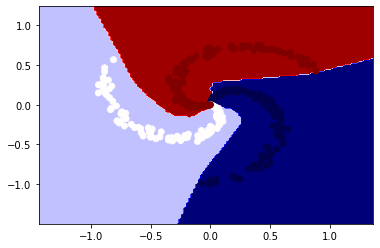

In [27]:
import dl_numpy as DL
import utilities
import matplotlib.pyplot as plt

batch_size        = 20
num_epochs        = 200
samples_per_class = 100
num_classes       = 3
hidden_units      = 100
data,target       = utilities.genSpiralData(samples_per_class,num_classes)
model             = utilities.Model()
model.add(DL.Linear(2,hidden_units))
model.add(ReLU())
model.add(DL.Linear(hidden_units,num_classes))
optim   = SGD(model.parameters,lr=1.0,weight_decay=0.001,momentum=.9)
loss_fn = SoftmaxWithLoss()
model.fit(data,target,batch_size,num_epochs,optim,loss_fn)
predicted_labels = np.argmax(model.predict(data),axis=1)
accuracy         = np.sum(predicted_labels==target)/len(target)
print("Model Accuracy = {}".format(accuracy))
plot2DDataWithDecisionBoundary(data,target,model)